In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import *

import warnings
warnings.filterwarnings("ignore")

C:\Users\emir.e\Anaconda3\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### First we obtain the top-3 largest volume cryptocurrencies from https://finance.yahoo.com/u/yahoo-finance/watchlists/crypto-top-volume-24hr/

In [2]:
# Download the data
BTC = yf.download("BTC-USD", start='2018-01-01', end='2024-01-01')['Adj Close']
ETH = yf.download("ETH-USD", start='2018-01-01', end='2024-01-01')['Adj Close']
USDT = yf.download("USDT-USD", start='2018-01-01', end='2024-01-01')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# Obtain Log Returns
rBTC=(np.log(BTC).diff().dropna())*100
rETH=(np.log(ETH).diff().dropna())*100
rUSDT=(np.log(USDT).diff().dropna())*100

#### Apply t-test for mean of both log returns

In [4]:
# t-test for the mean. test value=0
t_rBTC, p_rBTC = stats.ttest_1samp(rBTC, 0)
print(t_rBTC , p_rBTC)

t_rETH, p_rETH = stats.ttest_1samp(rETH, 0) 
print(t_rETH , p_rETH)

t_rUSDT, p_rUSDT = stats.ttest_1samp(rUSDT, 0)  
print(t_rUSDT , p_rUSDT)

0.655690356057455 0.5120922807020449
0.4872630676759868 0.6261207066170682
-0.04475645304245292 0.9643055179695463


#### T-statistics for both BTC and ETH is relatively low and p-values are significantly higher than 0.05 threshold, meaning that dataset is not statistically significantly different from 0, implying no strong evidence of growth or decline over these periods.

#### However, USDT shows a negative t-statistic and a very high p-value. This result strongly indicates that the mean of the rUSDT dataset is not statistically different from 0. Since Tether (USDT) is a stablecoin, typically pegged to a currency like the USD, this result is expected and indicates that it's maintaining its value as designed.

In [5]:
# Checked up to 10 lags
acorr_ljungbox(rBTC, lags=[10])

,lb_stat,lb_pvalue
10,17.763719,0.059083


In [6]:
acorr_ljungbox(rETH, lags=[10])

,lb_stat,lb_pvalue
10,34.070799,0.00018


In [7]:
acorr_ljungbox(rUSDT, lags=[10])

,lb_stat,lb_pvalue
10,435.225265,2.955147e-87


#### Performing Ljung-Box test up to 10 lags to understand if there's any autocorrelation;
#### The Bitcoin time series shows borderline evidence of autocorrelation, suggesting a need for further analysis.
#### The Ethereum time series demonstrates strong evidence of autocorrelation.
#### The Tether time series shows extremely strong evidence of autocorrelation, possibly due to its nature as a stablecoin.

In [8]:
# Demeaned Returns
rD_BTC = rBTC - np.mean(rBTC)
rD_ETH = rETH - np.mean(rETH)
rD_USDT = rUSDT - np.mean(rUSDT)

In [9]:
acorr_ljungbox(rD_BTC**2, lags=[10])

,lb_stat,lb_pvalue
10,56.231009,1.858172e-08


In [10]:
acorr_ljungbox(rD_ETH**2, lags=[10])

,lb_stat,lb_pvalue
10,85.761239,3.693657e-14


In [11]:
acorr_ljungbox(rD_USDT**2, lags=[10])

,lb_stat,lb_pvalue
10,631.84432,2.632537e-129


#### The squared demeaned returns have a very low p-value, indicating strong autocorrelation in volatility. This supports using a GARCH model to capture the volatility clustering evident in both cryptocurrencies' returns.

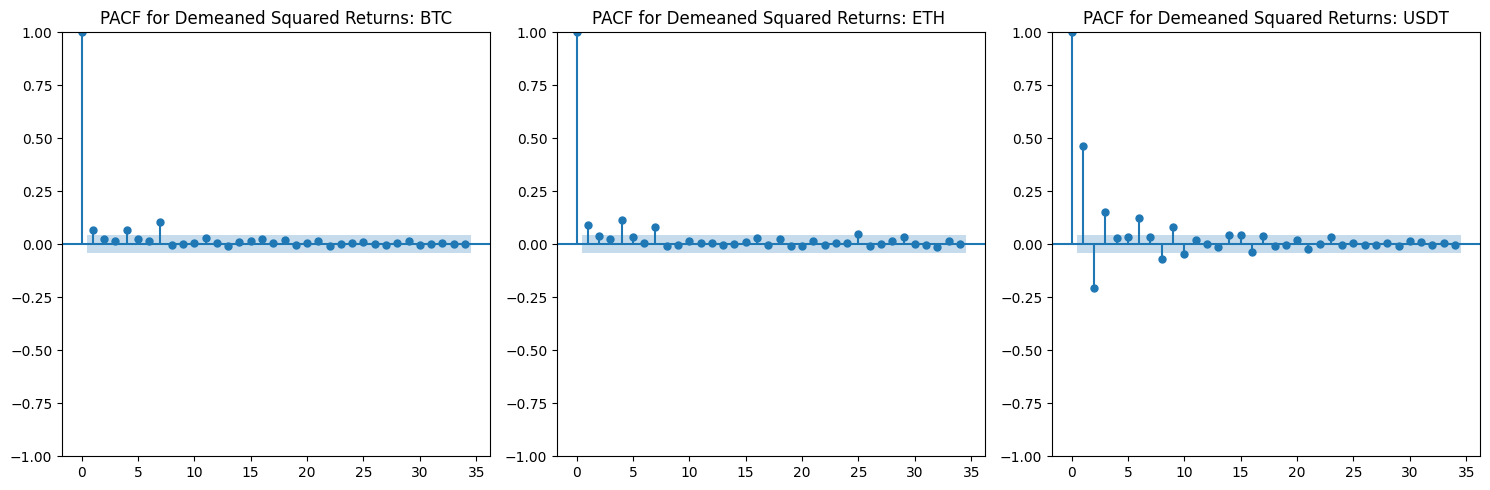

In [12]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot PACF for each dataset
plot_pacf(rD_BTC**2, ax=axs[0], title='PACF for Demeaned Squared Returns: BTC')
plot_pacf(rD_ETH**2, ax=axs[1], title='PACF for Demeaned Squared Returns: ETH ')
plot_pacf(rD_USDT**2, ax=axs[2], title='PACF for Demeaned Squared Returns: USDT')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

#### Significant cut-offs for BTC and ETH seem to happen in first lag, signifying that we should check an ARCH(1) model.
#### There are multiple seemingly significant lags beyond the first, but it's not clear without the confidence intervals. We will test ARCH(2) and ARCH(6) as well.

In [13]:
# ARCH(1) model estimation
BTC_AM1 = arch_model(rBTC, p=1, q=0, rescale=False)
BTC_res1 = BTC_AM1.fit(update_freq=0, disp='off')
print(BTC_res1.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5939.34
Distribution:                  Normal   AIC:                           11884.7
Method:            Maximum Likelihood   BIC:                           11901.7
                                        No. Observations:                 2190
Date:                Mon, Jan 29 2024   Df Residuals:                     2189
Time:                        16:30:09   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0628  7.687e-02      0.817      0.414 [-8.78

#### Error terms for BTC looks significant. Yet the p-value for mu suggests that the mean return is not significantly different from zero. Alpha[1] is greater than zero and shows statistical significance. Yet the high Akaine and Bayesian Information Criterion values suggest that ARCH(1) model may not be the best represantative of volatility in BTC returns. We might need to look for a GARCH model.
#### Also considering that BTC market is known for its high volatility and potentially non-normal distribution of returns, a model that assumes a normal distribution might not be the most appropriate for BTC. We should explore other distributions like Student's t or GED within the ARCH/GARCH framework.

In [14]:
ETH_AM1 = arch_model(rETH, p=1, q=0, rescale=False)
ETH_res1 = ETH_AM1.fit(update_freq=0, disp='off')
print(ETH_res1.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6493.90
Distribution:                  Normal   AIC:                           12993.8
Method:            Maximum Likelihood   BIC:                           13010.9
                                        No. Observations:                 2190
Date:                Mon, Jan 29 2024   Df Residuals:                     2189
Time:                        16:30:14   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0766  9.691e-02      0.791      0.429 [ -0.113,  0.26

#### Once again we cannot reject the null hypothesis on mu with high p-value. High AIC and BAC values also signal a room for improvement, by using higher lags or a GARCH model. 

In [15]:
rUSDT_AM1 = arch_model(rUSDT, p=1, q=0, rescale=False)
rUSDT_res1 = rUSDT_AM1.fit(update_freq=0, disp='off')
print(rUSDT_res1.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                74.0435
Distribution:                  Normal   AIC:                          -142.087
Method:            Maximum Likelihood   BIC:                          -125.012
                                        No. Observations:                 2190
Date:                Mon, Jan 29 2024   Df Residuals:                     2189
Time:                        16:30:17   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.0437e-03  6.516e-03      1.234      0.217 

In [16]:
rUSDT_AM2 = arch_model(rUSDT, p=2, q=0, rescale=False)
rUSDT_res2 = rUSDT_AM2.fit(update_freq=0, disp='off')
print(rUSDT_res2.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                392.208
Distribution:                  Normal   AIC:                          -776.415
Method:            Maximum Likelihood   BIC:                          -753.649
                                        No. Observations:                 2190
Date:                Mon, Jan 29 2024   Df Residuals:                     2189
Time:                        16:30:19   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.3962e-04  2.890e-03     -0.221      0.

In [17]:
rUSDT_AM6 = arch_model(rUSDT, p=6, q=0, rescale=False)
rUSDT_res6 = rUSDT_AM6.fit(update_freq=0, disp='off')
print(rUSDT_res6.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                929.512
Distribution:                  Normal   AIC:                          -1843.02
Method:            Maximum Likelihood   BIC:                          -1797.49
                                        No. Observations:                 2190
Date:                Mon, Jan 29 2024   Df Residuals:                     2189
Time:                        16:30:23   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.5046e-05  9.476e-04  3.699e-02      0.970 

C:\Users\emir.e\Anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [18]:
print(rUSDT_res1.aic, rUSDT_res1.bic)
print(rUSDT_res2.aic, rUSDT_res2.bic)
print(rUSDT_res6.aic, rUSDT_res6.bic)

-142.08691472035866 -125.01194425192702
-776.4152771010604 -753.6486498098182
-1843.0240943304243 -1797.4908397479398


#### Akaine and Bayesian Information Criteria (AIC and BAC) shows the measures with lowest values for ARCH(6) in USDT, but it shows high p-value in mu and higher lags show lesser significance. 
#### ARCH(2) model seems to be a good balance between model complexity and fit. It has significant coefficients for both lags, and although its log-likelihood is not as high as the ARCH(6) model, it is still significantly better than the ARCH(1) model. 
#### Yet we still have the issue with high p-value on mu for ARCH(2), yet another confirmation that we should look for GARCH models.
####  It is also worth noting that, for stablecoins, the absolute level of volatility may be less of a concern than for other cryptocurrencies, so the ARCH/GARCH modeling might be of more theoretical than practical interest.

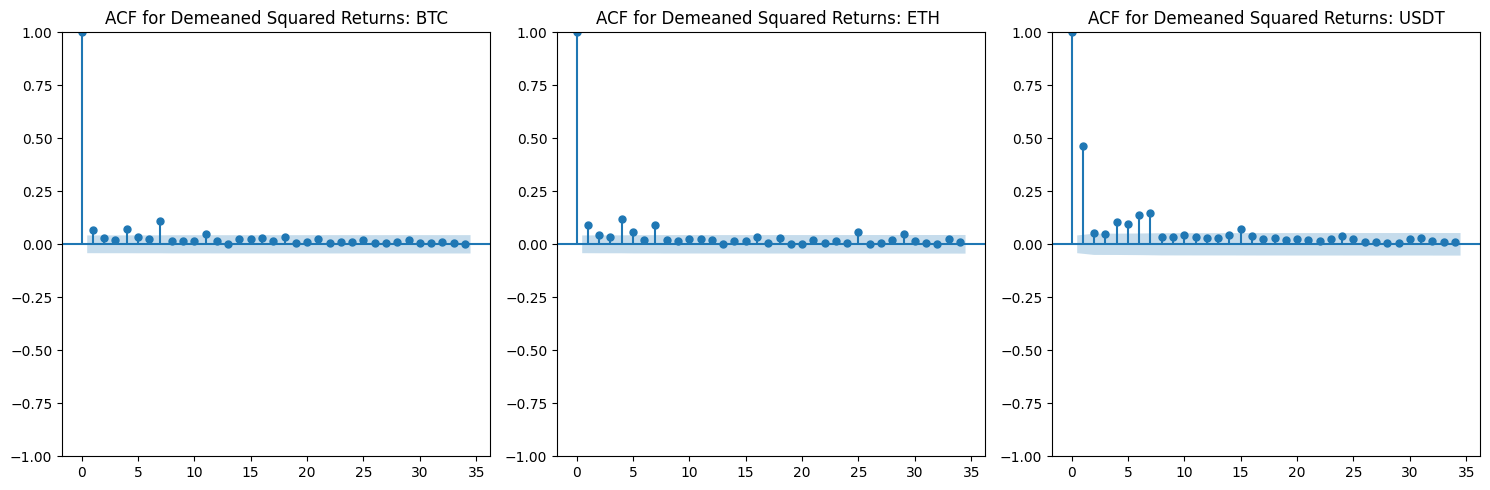

In [19]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot PACF for each dataset
plot_acf(rD_BTC**2, ax=axs[0], title='ACF for Demeaned Squared Returns: BTC')
plot_acf(rD_ETH**2, ax=axs[1], title='ACF for Demeaned Squared Returns: ETH ')
plot_acf(rD_USDT**2, ax=axs[2], title='ACF for Demeaned Squared Returns: USDT')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [20]:
BTC_GARCH = arch_model(rBTC, vol='Garch', p=1, q=1, rescale=False)
BTC_GARCH_res = BTC_GARCH.fit(update_freq=5, disp='off')
print(BTC_GARCH_res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5832.24
Distribution:                  Normal   AIC:                           11672.5
Method:            Maximum Likelihood   BIC:                           11695.3
                                        No. Observations:                 2190
Date:                Mon, Jan 29 2024   Df Residuals:                     2189
Time:                        16:30:36   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1248  7.545e-02      1.654  9.816e-02 [-2.31

#### GARCH(1,1) on BTC returns indicated a non-significant mean return, with p-value slightly above 0.05. Volatility modeling however revealed statistically significant omega, alpha and beta values, although the alpha representing the impact of previous day's volatility shock suggests a short-term volatility effect, along with beta's strong significance and coefficient being closer to one points out to a strong persistence of volatility over time. 
#### AIC and BIC show high values, indicating that we might need to look for alternative distributions.

In [21]:
ETH_GARCH = arch_model(rETH, vol='Garch', p=1, q=1, rescale=False)
ETH_GARCH_res = ETH_GARCH.fit(update_freq=5, disp='off')
print(ETH_GARCH_res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6357.10
Distribution:                  Normal   AIC:                           12722.2
Method:            Maximum Likelihood   BIC:                           12745.0
                                        No. Observations:                 2190
Date:                Mon, Jan 29 2024   Df Residuals:                     2189
Time:                        16:30:39   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0720  8.478e-02      0.849      0.396 [-9.41

#### GARCH(1,1) on ETH provided us with similar results to BTC, however the mean return (mu) and omega coefficients are not statistically significant. This suggests that the baseline volatility might be better captured with alternate distributions.

In [22]:
USDT_GARCH = arch_model(rUSDT, vol='Garch', p=1, q=1, rescale=False)
USDT_GARCH_res = USDT_GARCH.fit(update_freq=5, disp='off')
print(USDT_GARCH_res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                742.267
Distribution:                  Normal   AIC:                          -1476.53
Method:            Maximum Likelihood   BIC:                          -1453.77
                                        No. Observations:                 2190
Date:                Mon, Jan 29 2024   Df Residuals:                     2189
Time:                        16:30:41   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -3.4355e-04  1.100e-03     -0.312      0.

#### GARCH(1,1) applied to USDT returns shows non-significance in mu, which is an expected behavior of a stable coin typically pegged to the US dollar. The volatility parameter on the other hand tells a different story compared to BTC and ETH. The omega and alpha seem highly significant. What's unusual here for a stablecoin is that the beta coefficient is extremely significant with a magnitude close to 1, indicating a high level of persistence in volatility, which may suggest sensitivity to market conditions or reflect the dynamics of the time period analyzed.
#### Negative values on AIC and BIC shows a good fit. However since the practical implications of modeling the volatility of a stablecoin is limited, we will continue with different distributions on this one as well, just to compare the performance with models for BTC and ETH.

In [23]:
BTC_GARCH_t = arch_model(rBTC, vol='Garch', p=1, q=1, dist='t', rescale=False)
BTC_GARCH_t_res = BTC_GARCH_t.fit(update_freq=5, disp='off')
print(BTC_GARCH_t_res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -5522.32
Distribution:      Standardized Student's t   AIC:                           11054.6
Method:                  Maximum Likelihood   BIC:                           11083.1
                                              No. Observations:                 2190
Date:                      Mon, Jan 29 2024   Df Residuals:                     2189
Time:                              16:30:44   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

In [24]:
BTC_GARCH_ged = arch_model(rBTC, vol='Garch', p=1, q=1, dist='ged', rescale=False)
BTC_GARCH_ged_res = BTC_GARCH_ged.fit(update_freq=5, disp='off')
print(BTC_GARCH_ged_res.summary())

                           Constant Mean - GARCH Model Results                            
Dep. Variable:                          Adj Close   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:               -5529.90
Distribution:      Generalized Error Distribution   AIC:                           11069.8
Method:                        Maximum Likelihood   BIC:                           11098.3
                                                    No. Observations:                 2190
Date:                            Mon, Jan 29 2024   Df Residuals:                     2189
Time:                                    16:30:47   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------

In [25]:
print(BTC_GARCH_t_res.aic, BTC_GARCH_t_res.bic)
print(BTC_GARCH_ged_res.aic, BTC_GARCH_ged_res.bic)

11054.637314019812 11083.095598133865
11069.803510978536 11098.261795092589


#### Mean returns (mu) and omega are not significant in t-student GARCH(1,1) model. The model with Generalized Error Distribution (GED) reveals important characteristics in BTC, especially in terms of the heavy-tailed behaviour, yet it also shows an omega that's non-significant.
#### Comparing both models in terms of AIC and BIC, t-student distribution's values are slightly lower, suggesting a marginally better fit for data.

In [26]:
ETH_GARCH_t = arch_model(rETH, vol='Garch', p=1, q=1, dist='t', rescale=False)
ETH_GARCH_t_res = ETH_GARCH_t.fit(update_freq=5, disp='off')
print(ETH_GARCH_t_res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6155.76
Distribution:      Standardized Student's t   AIC:                           12321.5
Method:                  Maximum Likelihood   BIC:                           12350.0
                                              No. Observations:                 2190
Date:                      Mon, Jan 29 2024   Df Residuals:                     2189
Time:                              16:30:54   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

In [27]:
ETH_GARCH_ged = arch_model(rETH, vol='Garch', p=1, q=1, dist='ged', rescale=False)
ETH_GARCH_ged_res = ETH_GARCH_ged.fit(update_freq=5, disp='off')
print(ETH_GARCH_ged_res.summary())

                           Constant Mean - GARCH Model Results                            
Dep. Variable:                          Adj Close   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:               -6158.88
Distribution:      Generalized Error Distribution   AIC:                           12327.8
Method:                        Maximum Likelihood   BIC:                           12356.2
                                                    No. Observations:                 2190
Date:                            Mon, Jan 29 2024   Df Residuals:                     2189
Time:                                    16:30:56   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------

In [28]:
print(ETH_GARCH_t_res.aic, ETH_GARCH_t_res.bic)
print(ETH_GARCH_ged_res.aic, ETH_GARCH_ged_res.bic)

12321.51471379348 12349.972997907533
12327.763234996222 12356.221519110275


#### Once again we see a similar scenario to BTC on ETH's t-distribution and GED. Mean returns (mu) is not statistically significant on t-distribution, where GED shows significance. Omega is statistically insignificant on both and once again it comes down to AIC and BIC. We obtain better Goodness of Fit on t-distribution model for ETH due to slightly lower AIC and BIC.

#### So from here on, we will test with different GARCH models to obtain the best fit on t-distribution.

In [29]:
# EGARCH
BTC_EGARCH_t = arch_model(rBTC, vol='EGARCH', p=1, q=1, dist='t', rescale=False)
BTC_EGARCH_t_res = BTC_EGARCH_t.fit(update_freq=5, disp='off')
print(BTC_EGARCH_t_res.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -5509.46
Distribution:      Standardized Student's t   AIC:                           11028.9
Method:                  Maximum Likelihood   BIC:                           11057.4
                                              No. Observations:                 2190
Date:                      Mon, Jan 29 2024   Df Residuals:                     2189
Time:                              16:31:01   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

In [30]:
# AR-CGARCH
BTC_AR_GARCH = arch_model(rBTC, mean='AR', lags=1, vol='Garch', p=1, q=1, o=1, dist='t', rescale=False)
BTC_AR_GARCH_res = BTC_AR_GARCH.fit(update_freq=5, disp='off')
print(BTC_AR_GARCH_res.summary())

                            AR - GJR-GARCH Model Results                            
Dep. Variable:                    Adj Close   R-squared:                       0.002
Mean Model:                              AR   Adj. R-squared:                  0.001
Vol Model:                        GJR-GARCH   Log-Likelihood:               -5513.71
Distribution:      Standardized Student's t   AIC:                           11041.4
Method:                  Maximum Likelihood   BIC:                           11081.3
                                              No. Observations:                 2189
Date:                      Mon, Jan 29 2024   Df Residuals:                     2187
Time:                              16:31:04   Df Model:                            2
                                   Mean Model                                   
                   coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------

In [31]:
# GJR-GARCH
BTC_GJR_GARCH = arch_model(rBTC, mean='Constant', p=1, o=1, q=1, dist='t')
BTC_GJR_GARCH_res = BTC_GJR_GARCH.fit(update_freq=0, disp='off')
print(BTC_GJR_GARCH_res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -5522.09
Distribution:      Standardized Student's t   AIC:                           11056.2
Method:                  Maximum Likelihood   BIC:                           11090.3
                                              No. Observations:                 2190
Date:                      Mon, Jan 29 2024   Df Residuals:                     2189
Time:                              16:31:07   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

In [32]:
print(BTC_EGARCH_t_res.aic, BTC_EGARCH_t_res.bic)
print(BTC_AR_GARCH_res.aic, BTC_AR_GARCH_res.bic)
print(BTC_GJR_GARCH_res.aic, BTC_GJR_GARCH_res.bic)

11028.91469112962 11057.372975243672
11041.424570110024 11081.262970792684
11056.18292766303 11090.332868599893


In [33]:
print(BTC_EGARCH_t_res.pvalues['mu'])
print(BTC_AR_GARCH_res.pvalues['Const'], BTC_AR_GARCH_res.pvalues['Adj Close[1]'])
print(BTC_GJR_GARCH_res.pvalues['mu'])

0.20189572423239677
0.1160874668404067 0.0043684781383526395
0.13551100468831973


#### Upon taking a look at AIC and BIC values for both models, EGARCH[1,1] looks to be the one with least values. However AR-GJR-GARCH model shows the least difference from 0.05 significance level, along with a significant p-value in Adjusted Closing prices. This verifies that complexity of the model with inclusion of AR in mean equation captures more nuances in the data, at the risk of overfitting.

In [34]:
# EGARCH
ETH_EGARCH_t = arch_model(rETH, vol='EGARCH', p=1, q=1, dist='t', rescale=False)
ETH_EGARCH_t_res = ETH_EGARCH_t.fit(update_freq=5, disp='off')
print(ETH_EGARCH_t_res.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -6144.54
Distribution:      Standardized Student's t   AIC:                           12299.1
Method:                  Maximum Likelihood   BIC:                           12327.5
                                              No. Observations:                 2190
Date:                      Mon, Jan 29 2024   Df Residuals:                     2189
Time:                              16:31:15   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

In [35]:
# AR-CGARCH
ETH_AR_GARCH = arch_model(rETH, mean='AR', lags=1, vol='Garch', p=1, q=1, o=1, dist='t', rescale=False)
ETH_AR_GARCH_res = ETH_AR_GARCH.fit(update_freq=5, disp='off')
print(ETH_AR_GARCH_res.summary())

                            AR - GJR-GARCH Model Results                            
Dep. Variable:                    Adj Close   R-squared:                       0.002
Mean Model:                              AR   Adj. R-squared:                  0.002
Vol Model:                        GJR-GARCH   Log-Likelihood:               -6141.41
Distribution:      Standardized Student's t   AIC:                           12296.8
Method:                  Maximum Likelihood   BIC:                           12336.7
                                              No. Observations:                 2189
Date:                      Mon, Jan 29 2024   Df Residuals:                     2187
Time:                              16:31:17   Df Model:                            2
                                  Mean Model                                 
                   coef    std err          t      P>|t|     95.0% Conf. Int.
-----------------------------------------------------------------------------
C

In [36]:
# GJR-GARCH
ETH_GJR_GARCH = arch_model(rETH, mean='Constant', p=1, o=1, q=1, dist='t')
ETH_GJR_GARCH_res = ETH_GJR_GARCH.fit(update_freq=0, disp='off')
print(ETH_GJR_GARCH_res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -6155.25
Distribution:      Standardized Student's t   AIC:                           12322.5
Method:                  Maximum Likelihood   BIC:                           12356.7
                                              No. Observations:                 2190
Date:                      Mon, Jan 29 2024   Df Residuals:                     2189
Time:                              16:31:19   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

In [37]:
print(ETH_EGARCH_t_res.aic, ETH_EGARCH_t_res.bic)
print(ETH_AR_GARCH_res.aic, ETH_AR_GARCH_res.bic)
print(ETH_GJR_GARCH_res.aic, ETH_GJR_GARCH_res.bic)

12299.071900156101 12327.530184270154
12296.826842480601 12336.665243163261
12322.505640663883 12356.655581600746


In [38]:
print(ETH_EGARCH_t_res.pvalues['mu'])
print(ETH_AR_GARCH_res.pvalues['Const'], ETH_AR_GARCH_res.pvalues['Adj Close[1]'])
print(ETH_GJR_GARCH_res.pvalues['mu'])

0.3014841561313658
0.1458440832061296 1.929726487157061e-05
0.1729419192654913


#### Again we see a similar scenario with ETH as well, where AIC and BIC prompts the best fit in EGARCH[1,1] and we obtain the closest level in Constant's p-value and statistical significance in Adjusted Close's p-value in AR-GJR-GARCH.

In [39]:
# EGARCH
USDT_EGARCH_t = arch_model(rUSDT, vol='EGARCH', p=1, q=1, dist='t', rescale=False)
USDT_EGARCH_t_res = USDT_EGARCH_t.fit(update_freq=5, disp='off')
print(USDT_EGARCH_t_res.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                1916.73
Distribution:      Standardized Student's t   AIC:                          -3823.46
Method:                  Maximum Likelihood   BIC:                          -3795.01
                                              No. Observations:                 2190
Date:                      Mon, Jan 29 2024   Df Residuals:                     2189
Time:                              16:31:27   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [40]:
# AR-CGARCH
USDT_AR_GARCH = arch_model(rUSDT, mean='AR', lags=1, vol='Garch', p=1, q=1, o=1, dist='t', rescale=False)
USDT_AR_GARCH_res = USDT_AR_GARCH.fit(update_freq=5, disp='off')
print(USDT_AR_GARCH_res.summary())

                            AR - GJR-GARCH Model Results                            
Dep. Variable:                    Adj Close   R-squared:                       0.171
Mean Model:                              AR   Adj. R-squared:                  0.171
Vol Model:                        GJR-GARCH   Log-Likelihood:                1389.40
Distribution:      Standardized Student's t   AIC:                          -2764.81
Method:                  Maximum Likelihood   BIC:                          -2724.97
                                              No. Observations:                 2189
Date:                      Mon, Jan 29 2024   Df Residuals:                     2187
Time:                              16:31:30   Df Model:                            2
                                    Mean Model                                   
                    coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------

In [41]:
# GJR-GARCH
USDT_GJR_GARCH = arch_model(rUSDT, mean='Constant', p=1, o=1, q=1, dist='t')
USDT_GJR_GARCH_res = USDT_GJR_GARCH.fit(update_freq=0, disp='off')
print(USDT_GJR_GARCH_res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                1193.12
Distribution:      Standardized Student's t   AIC:                          -2374.24
Method:                  Maximum Likelihood   BIC:                          -2340.09
                                              No. Observations:                 2190
Date:                      Mon, Jan 29 2024   Df Residuals:                     2189
Time:                              16:31:33   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------

In [42]:
print(USDT_EGARCH_t_res.aic, USDT_EGARCH_t_res.bic)
print(USDT_AR_GARCH_res.aic, USDT_AR_GARCH_res.bic)
print(USDT_GJR_GARCH_res.aic, USDT_GJR_GARCH_res.bic)

-3823.4637710485235 -3795.005486934471
-2764.8068897314506 -2724.9684890487906
-2374.235236684422 -2340.0852957475586


In [43]:
print(USDT_EGARCH_t_res.pvalues['mu'])
print(USDT_AR_GARCH_res.pvalues['Const'], USDT_AR_GARCH_res.pvalues['Adj Close[1]'])
print(USDT_GJR_GARCH_res.pvalues['mu'])

0.244838824369235
0.01461439679962379 5.755009897090783e-43
0.026738069620285326


#### Same pattern verifies itself over on USDT as well, where EGARCH shows the least negative values in AIC and BIC. But a key difference here is that USDT shows statistical significance in Const and Adj Close below 0.05 for AR-GJR-GARCH model. 

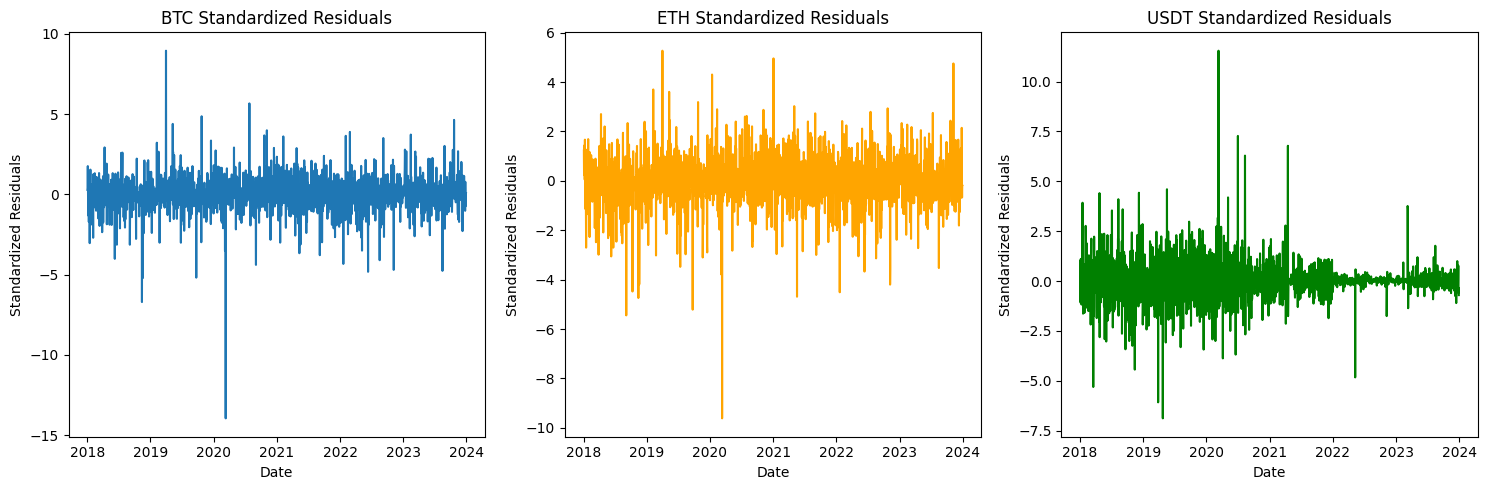

In [44]:
# Standardized residuals for each cryptocurrency
BTC_resid = BTC_AR_GARCH_res.resid / BTC_AR_GARCH_res.conditional_volatility
ETH_resid = ETH_AR_GARCH_res.resid / ETH_AR_GARCH_res.conditional_volatility
USDT_resid = USDT_AR_GARCH_res.resid / USDT_AR_GARCH_res.conditional_volatility

tdx_btc = pd.date_range(start='2018-01-01', periods=len(BTC_resid), freq='D')
tdx_eth = pd.date_range(start='2018-01-01', periods=len(ETH_resid), freq='D')
tdx_usdt = pd.date_range(start='2018-01-01', periods=len(USDT_resid), freq='D')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot standardized residuals for each cryptocurrency
axs[0].plot(tdx_btc, BTC_resid, label='BTC')
axs[0].set_title('BTC Standardized Residuals')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Standardized Residuals')

axs[1].plot(tdx_eth, ETH_resid, label='ETH', color='orange')
axs[1].set_title('ETH Standardized Residuals')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Standardized Residuals')

axs[2].plot(tdx_usdt, USDT_resid, label='USDT', color='green')
axs[2].set_title('USDT Standardized Residuals')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Standardized Residuals')

plt.tight_layout()
plt.show()

#### Now considering that The first US bitcoin (BTC) exchange-traded fund (ETF), "BITO", started trading on 19 October 2021, we can already see some changes in the volatility at late 2021 in USDT Standardized Residuals. Yet we need to confirm our model with additional tests.

In [45]:
BTC_std_resid = BTC_resid.dropna()
ETH_std_resid = ETH_resid.dropna()
USDT_std_resid = USDT_resid.dropna()

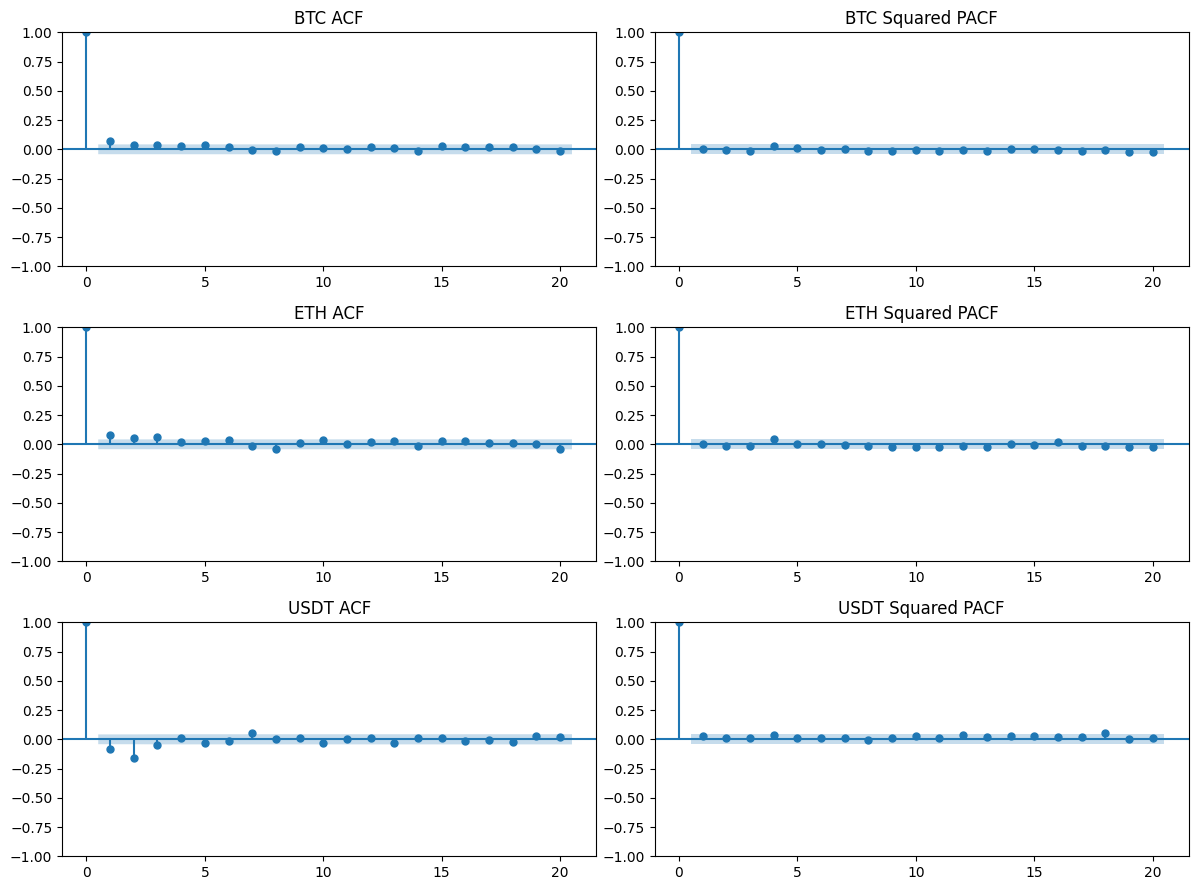

In [46]:
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

# Plot ACF and PACF for BTC Standardized Residuals
plot_acf(BTC_std_resid, lags=20, ax=axes[0, 0], title='BTC ACF')
plot_pacf(BTC_std_resid**2, lags=20, ax=axes[0, 1], title='BTC Squared PACF')

plot_acf(ETH_std_resid, lags=20, ax=axes[1, 0], title='ETH ACF')
plot_pacf(ETH_std_resid**2, lags=20, ax=axes[1, 1], title='ETH Squared PACF')

plot_acf(USDT_std_resid, lags=20, ax=axes[2, 0], title='USDT ACF')
plot_pacf(USDT_std_resid**2, lags=20, ax=axes[2, 1], title='USDT Squared PACF')

plt.tight_layout()
plt.show()

In [47]:
lags = 10
BTC_lb = acorr_ljungbox(BTC_std_resid, lags=[lags], return_df=True)
print(BTC_lb)

      lb_stat  lb_pvalue
10  22.872275   0.011228


In [48]:
ETH_lb = acorr_ljungbox(ETH_std_resid, lags=[lags], return_df=True)
print(ETH_lb)

      lb_stat  lb_pvalue
10  37.674302   0.000043


In [49]:
USDT_lb = acorr_ljungbox(USDT_std_resid, lags=[lags], return_df=True)
print(USDT_lb)

      lb_stat     lb_pvalue
10  84.995362  5.230738e-14


#### For BTC: The p-value is less than the common alpha level of 0.05, we reject the null hypothesis that there is no autocorrelation in the residuals at the first 10 lags. This suggests that the model may not be fully capturing the dynamics of the BTC returns, and there might be some autocorrelation left in the residuals.

#### For ETH: We have a statistically significant p-value, which leads to rejection of the null hypothesis of no autocorrelation in the residuals at the first 10 lags. Similar to BTC, the current model may not be adequate in explaining the ETH returns, as there appears to be significant autocorrelation remaining in the residuals.

#### For USDT: We have an extremely small p-value that once again allows us to reject the null hypothesis.

In [50]:
import statsmodels.api as sm

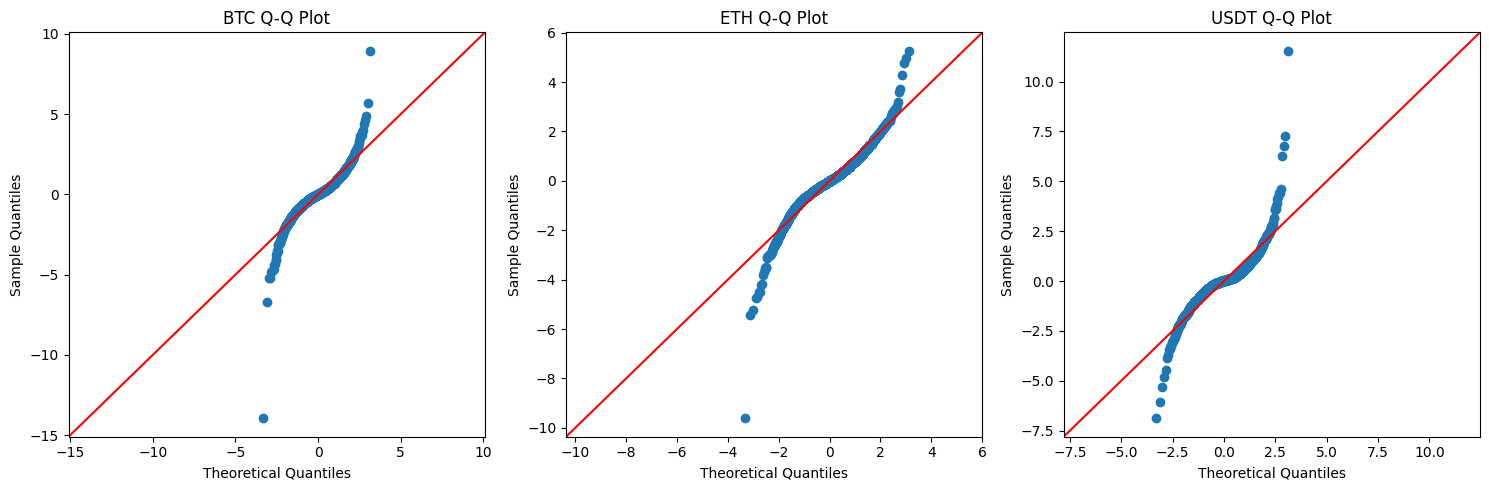

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sm.qqplot(BTC_AR_GARCH_res.std_resid, line='45', ax=axes[0])
axes[0].set_title('BTC Q-Q Plot')

sm.qqplot(ETH_AR_GARCH_res.std_resid, line='45', ax=axes[1])
axes[1].set_title('ETH Q-Q Plot')

sm.qqplot(USDT_AR_GARCH_res.std_resid, line='45', ax=axes[2])
axes[2].set_title('USDT Q-Q Plot')

plt.tight_layout()
plt.show()

#### Using a Q-Q Plot to compare the distribution of the standardized residuals from out AR-GJR-GARCH model to a theoretical normal distribution, we can see that the middle points of our data falls over the line, yet we see clear deviations at especially the lower tails. This means that the residuals have heavier tails than the normal distribution, which point out to a higher occurrence of smaller or larger extreme values. Such heavy tails mean that addition of risk measures such as Value at Risk (VaR) or Expected Shortfall(ES) would improve the model further.

### So the Mean and Variance Equations for our model will be;

# $$ Mean : r_t = \mu + \phi * r_{t-1} + \epsilon_t $$

### Where $r^2_t$ is the return at time t
### $\mu$ is the constant term
### $\phi$ is the coefficient for the first lag of the return series
### $\epsilon_t$ is the error term at time t

# $$ Variance : \sigma^2_t = \omega + (\alpha + \gamma * I_{t-1}) * \epsilon^2_{t-1} + \beta * \sigma^2_{t-1} $$ 

### Where $\sigma^2_t$ is the conditional variance at time t
### $\omega$ is the constant term in variance
### $\alpha$ is the parameter for lagged squared error term
### $\gamma$ is the leverage effect parameter to capture the asymmetric impact of negative shos on future volatility
### $I_{t-1}$ is an indicator function that takes the value of "1" if $\epsilon_{t-1} < 0$ and becomes "0" otherwise
### $\epsilon^2_{t-1}$ is the error term from the previous time period
### $\beta$ is the autoregressive parameter for the lagged conditional variance


#### -------------------------------

### So what we have is :

### $$ {Mean}_{(BTC)} : r_t = 0.0689 + (-0.0537) * r_{t-1} + \epsilon_t $$
### $$ {Variance}_{(BTC)} : \sigma^2_t = 0.0923 + (0.0735 + (-0.0113) * I_{t-1}) * \epsilon^2_{t-1} +  0.9322 * \sigma^2_{t-1} $$ 

### $$ {Mean}_{(ETH)} : r_t = 0.0930 + (-0.0843) * r_{t-1} + \epsilon_t $$
### $$ {Variance}_{(ETH)} : \sigma^2_t = 0.2767 + (0.1008 + (-0.0253) * I_{t-1}) * \epsilon^2_{t-1} +  0.9118 * \sigma^2_{t-1} $$ 

### $$ {Mean}_{(USDT)} : r_t = ((-0.0019971) + (-0.3710)) * r_{t-1} + \epsilon_t $$
### $$ {Variance}_{(USDT)} : \sigma^2_t = 0.0021322 + (0.2009 + 0.1998 * I_{t-1}) * \epsilon^2_{t-1} +  0.6792 * \sigma^2_{t-1} $$ 

#### Now let's split the timeframe on both assets, to observe how the date that the BITO ETF started trading have affected the volatility.

In [52]:
BTC_B = yf.download("BTC-USD", start='2018-01-01', end='2021-10-19')['Adj Close']
ETH_B = yf.download("ETH-USD", start='2018-01-01', end='2021-10-19')['Adj Close']
USDT_B = yf.download("USDT-USD", start='2018-01-01', end='2021-10-19')['Adj Close']

BTC_F = yf.download("BTC-USD", start='2021-10-20', end='2024-01-01')['Adj Close']
ETH_F = yf.download("ETH-USD", start='2021-10-20', end='2024-01-01')['Adj Close']
USDT_F = yf.download("USDT-USD", start='2021-10-20', end='2024-01-01')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [53]:
# Obtain Log Returns
rBTC_B=(np.log(BTC_B).diff().dropna())*100
rETH_B=(np.log(ETH_B).diff().dropna())*100
rUSDT_B=(np.log(USDT_B).diff().dropna())*100

rBTC_F=(np.log(BTC_F).diff().dropna())*100
rETH_F=(np.log(ETH_F).diff().dropna())*100
rUSDT_F=(np.log(USDT_F).diff().dropna())*100

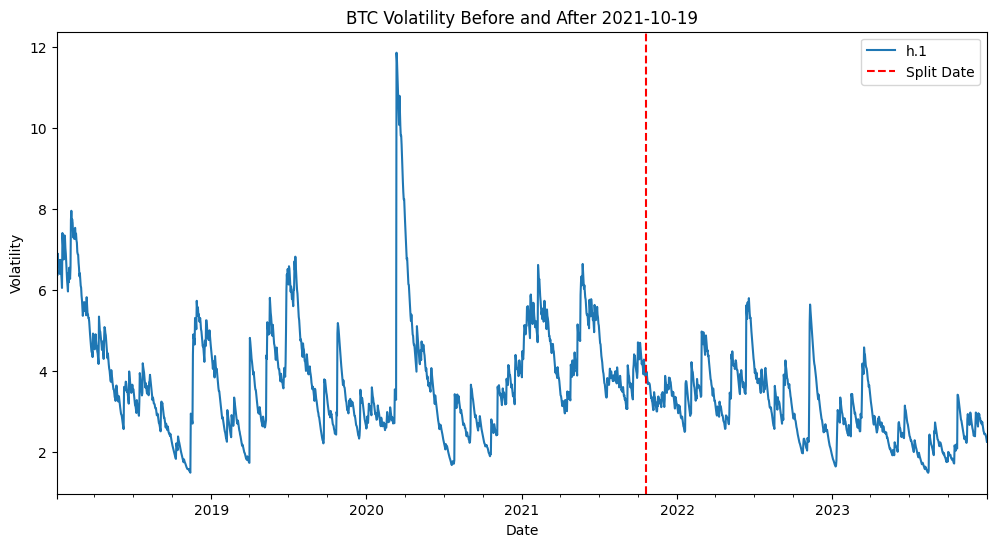

In [54]:
BTC_AR_GARCH_fit = BTC_AR_GARCH.fit(last_obs='2021-10-19', update_freq=5, disp='off')

BTC_forecast = BTC_AR_GARCH_fit.forecast(start='2021-10-20', method='simulation')

BTC_forecast = BTC_AR_GARCH_fit.forecast(start='2018-01-01', horizon=1, method='simulation')

# Extract the forecasted variance and take the square root for volatility
BTC_vol_f = BTC_forecast.variance**0.5

# Create a combined volatility series
BTC_vol_combined = BTC_vol_f['h.1'].dropna()

# Plot the combined volatility
plt.figure(figsize=(12, 6))
BTC_vol_combined.plot(title='BTC Volatility Before and After 2021-10-19')
plt.axvline(x='2021-10-19', color='red', linestyle='--', label='Split Date')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

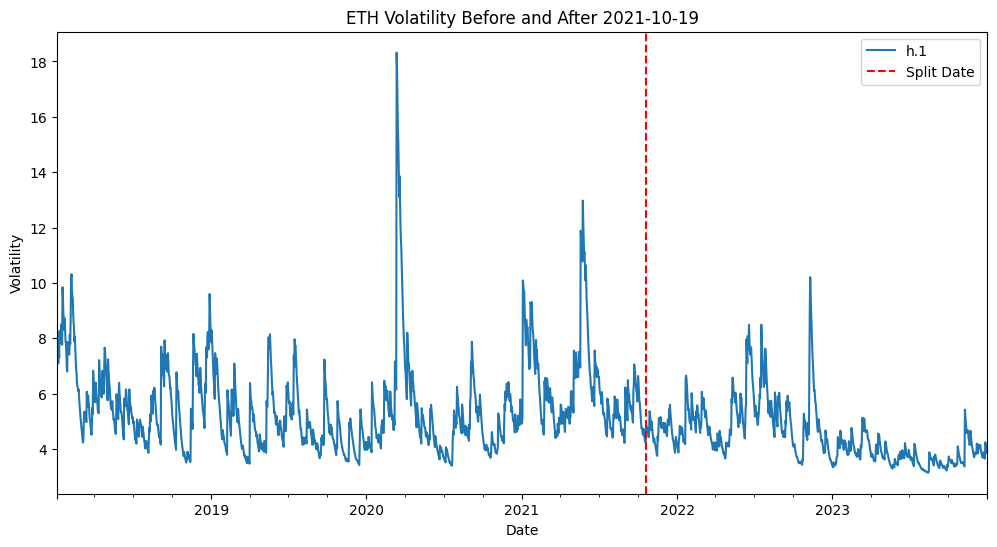

In [55]:
ETH_AR_GARCH_fit = ETH_AR_GARCH.fit(last_obs='2021-10-19', update_freq=5, disp='off')

ETH_forecast = ETH_AR_GARCH_fit.forecast(start='2021-10-20', method='simulation')

ETH_forecast = ETH_AR_GARCH_fit.forecast(start='2018-01-01', horizon=1, method='simulation')

# Extract the forecasted variance and take the square root for volatility
ETH_vol_f = ETH_forecast.variance**0.5

# Create a combined volatility series
ETH_vol_combined = ETH_vol_f['h.1'].dropna()

# Plot the combined volatility
plt.figure(figsize=(12, 6))
ETH_vol_combined.plot(title='ETH Volatility Before and After 2021-10-19')
plt.axvline(x='2021-10-19', color='red', linestyle='--', label='Split Date')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

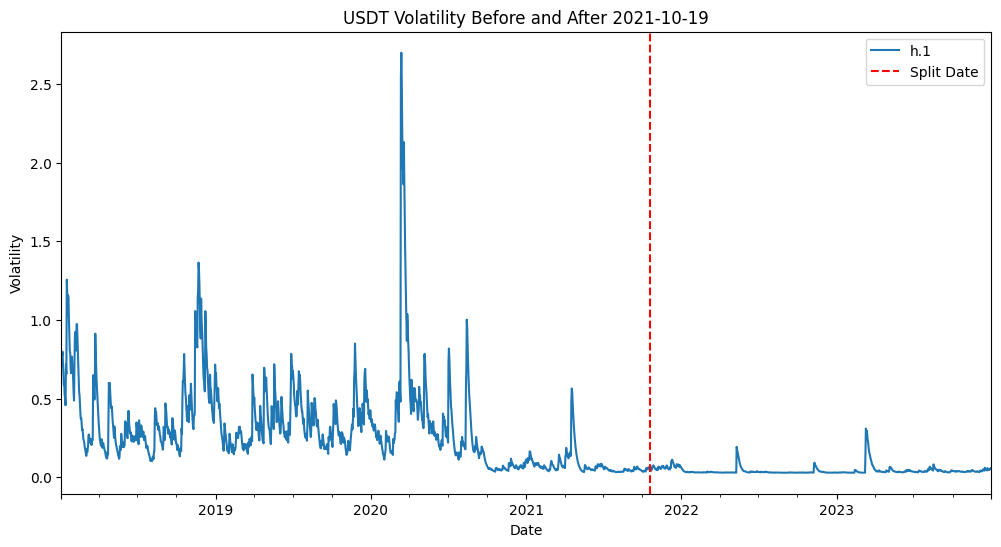

In [56]:
USDT_AR_GARCH_fit = USDT_AR_GARCH.fit(last_obs='2021-10-19', update_freq=5, disp='off')

USDT_forecast = USDT_AR_GARCH_fit.forecast(start='2021-10-20', method='simulation')

USDT_forecast = USDT_AR_GARCH_fit.forecast(start='2018-01-01', horizon=1, method='simulation')

# Extract the forecasted variance and take the square root for volatility
USDT_vol_f = USDT_forecast.variance**0.5

# Create a combined volatility series
USDT_vol_combined = USDT_vol_f['h.1'].dropna()

# Plot the combined volatility
plt.figure(figsize=(12, 6))
USDT_vol_combined.plot(title='USDT Volatility Before and After 2021-10-19')
plt.axvline(x='2021-10-19', color='red', linestyle='--', label='Split Date')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### Plots leave little for interpretation, since our models used for forecasting the before and after the selected date shows a clear decrease in volatility of BTC and ETH, which becomes more evident in USDT.